# Bayesian Change Point Model in Discrete Space

## \*\*\* Utils \*\*\*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special as sp
import pandas as pd
from operator import attrgetter
from IPython.display import Image
%matplotlib inline
np.set_printoptions(precision=8)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr/np.sum(pr))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=0):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

def normalize(A, axis=0):
    Z = np.sum(A, axis=axis, keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def safe_log_sum_exp(x):
    max_const = np.max(x)
    log_sum_exp = np.log(np.sum(np.exp(x - max_const)))
    return log_sum_exp + max_const

def load_array(filename):
    X = np.loadtxt(filename)
    dim = int(X[0]);
    size = []
    for i in range(dim):
        size.append(int(X[i+1]));    
    X = np.reshape(X[dim+1:], size, order='F')
    return X;
        
def save_array(filename, X, format = '%.6f'):
    with open(filename, 'w') as f:
        dim = len(X.shape)
        f.write('%d\n' % dim)
        for i in range(dim):
            f.write('%d\n' % X.shape[i])
        temp = X.reshape(np.product(X.shape), order='F')
        for num in temp:
            f.write(str(num)+"\n")
        # np.savetxt(f, temp, fmt = format)

## Reset-HMM-LDS

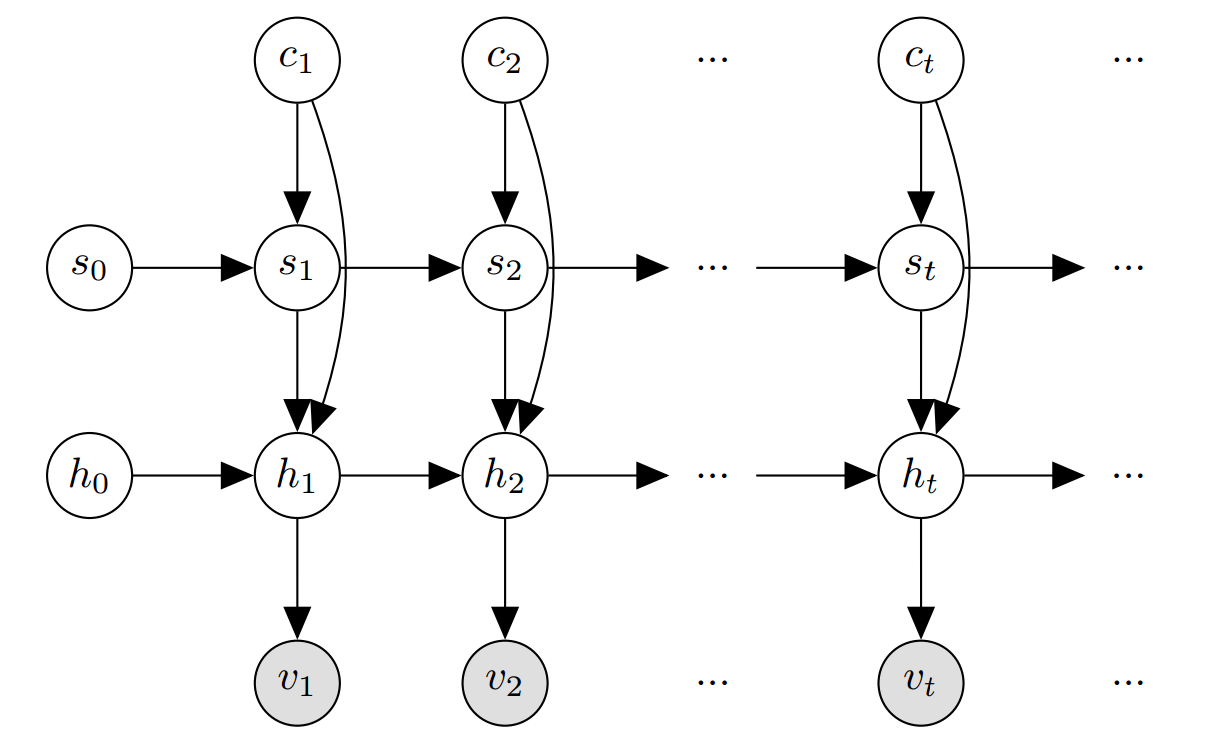

In [2]:
Image(filename='etc/reset-hmm-lds.png', width=500, height=200)

* $S$: Number of models
* $M$: The length of the observation vector
* $c_t \in \{0,1\}$, where 0 represents no change and 1 represents a change
* $s_t \in \{1,2,...,S\}$

\begin{align}
h_0  &\sim p(h_0) \\
s_0  &\sim p(s_0) \\
s_t  &\sim p(s_t|c_t,s_{t-1}) \\
h_t  &\sim p(h_t|s_t,h_{t-1}) \\
y_t  &\sim p(y_t|h_t)
\end{align}

Change point probability in this model is defined in terms of a change on the Markov chain on $s_t$. In other words,
\begin{align}
p(c_t=1|s_t, s_{t-1}) &= [s_t \neq s_{t-1}] 
\end{align}

Hidden states $h_t$ in this model are conditioned on the model, $s_t$ (In our previous model, it was conditioned only on the switch). Thus, we do not necessarily propagate particles as they are, new rules that may modify particles depending upon the model at current time could be considered. For the time being, we just ignore this dependency:
\begin{align}
p(h_t=1|h_{t-1},s_t,c_t) &= [c_t=0]\delta(h_t-h_{t-1}) + [c_t=1]p(h_t|s_t)
\end{align}
In each time step, $S$ additional particles are created, in addition to those that are propagated. The normalizing constant of each propagated particle is updated by the log of no change probability. That of each newly created particle is updated by the log of change probability plus the log of new model's probability.

## Generative Model

The model is in discrete space. This is to say, latent variables $\pi_i$ are simply $N$ dimensional probability vectors over hidden variables and the transition between latent variables are governed by a $N\times N$ matrix $A$, if $N$ is the number of hidden states. In our setup, observation model is also discrete and governed by a $M\times N$ matrix $M$, where there exist $C$ different observations. Switches are at the highest level in the hierarchy. In our simple example, we assume that switches are binary variables.

\begin{align}
x_0  &\sim p(x_0; \pi) \\
r_t  &\sim \mathcal{BE}(r_t; c) \\
x_t | r_t, x_{t-1}  &\sim [r_{t}=0] \delta(x_{t} - x_{t-1}) + [r_{t}=1] p(x_t| \pi)\\
y_t | x_t  &\sim p(y_t | x_t)
\end{align}

We again have mixture components, in which we store the potential on $x_t$ and the normalization constant in the log domain. 

In [3]:
class MixtureComponent:
    def __init__(self,log_x_,log_c_):
        self.log_x = log_x_
        self.log_c = log_c_
    def copy(self):
        return MixtureComponent(self.log_x.copy(), self.log_c)

In [26]:
# Reset-HMM-LDS at Barber's book

# c1   c2   c3   c4
# |    |    |    |
# s1-->s2-->s3-->s4
# |    |    |    |
# h1-->h2-->h3-->h4
# |    |    |    |
# v1   v2   v3   v4 

class DBCPM:
    def set_c(self, c_):
        self.c = c_
        self.log_c = np.log(self.c)
    def set_pi(self, pi_):
        self.pi = normalize(pi_)
        self.log_pi = np.log(self.pi)
    def set_A(self, A_):
        self.A = normalize(A_)
        self.log_A = np.log(self.A)
    def set_B(self, B_):
        self.B = normalize(B_)
        self.log_B = np.log(self.B)
        
    def __init__(self, c_, pi_, A_, B_):
        self.set_c(c_)      # change point probability
        self.set_pi(pi_)    # reset probabilities
        self.set_A(A_)      # colums store reset params
        self.set_B(B_)      # observation matrix
        self.M = self.B.shape[0]    # number of observations
        self.S = self.B.shape[1]    # number of models
          
    @staticmethod
    def init(S_=5, M_=12, c_=0.05):
        pi_ = np.ones(S_)               # flat prior
        # pi_[-1] = 100
        A_ = np.eye(S_) + 0.1           # each model favors its index
        A_[:,-1] = np.ones(S_)
        B_ = np.random.random((M_, S_)) # random observation model
        # tmp = np.random.permutation(np.arange(int(M_/S_)*S_))
        tmp = np.arange(int(M_/S_)*S_)
        tmp = np.reshape(tmp,(S_,int(M_/S_)))
        for i in range(S_):
            B_[tmp[i,:],i] += 5
        dbcpm = DBCPM(c_, pi_, A_, B_)
        return dbcpm
        
    def gen_data(self, T=50):
        C = np.random.binomial(1,self.c,size=T)
        cps = np.where(C==1)[0]
        S = np.zeros(T)
        H = np.zeros((self.S,T))
        V = np.zeros((self.M,T))
        for t in range(T):
            if t==0:
                C[t] = 0
                S[t] = randgen(self.pi)
                H[:, t] = self.A[:, S[t]] 
            elif C[t]:
                S[t] = randgen(self.pi)
                while S[t] == S[t-1]:
                    S[t] = randgen(self.pi)
                H[:, t] = self.A[:, S[t]] 
            else:
                S[t] = S[t-1]
                H[:,t] = H[:,t-1]
            V[:,t] = np.random.multinomial(50,np.dot(self.B, H[:,t]))
        return cps, C, S, H, V

[[ 0.36857546  0.0629689   0.01820889]
 [ 0.36541402  0.03355909  0.0151235 ]
 [ 0.07178111  0.36795925  0.05637373]
 [ 0.06326005  0.35111661  0.04148901]
 [ 0.03668123  0.04535908  0.46014958]
 [ 0.06014272  0.05466503  0.40683303]
 [ 0.02834451  0.03592792  0.00132821]
 [ 0.0058009   0.04844411  0.00049404]]


/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cagatay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


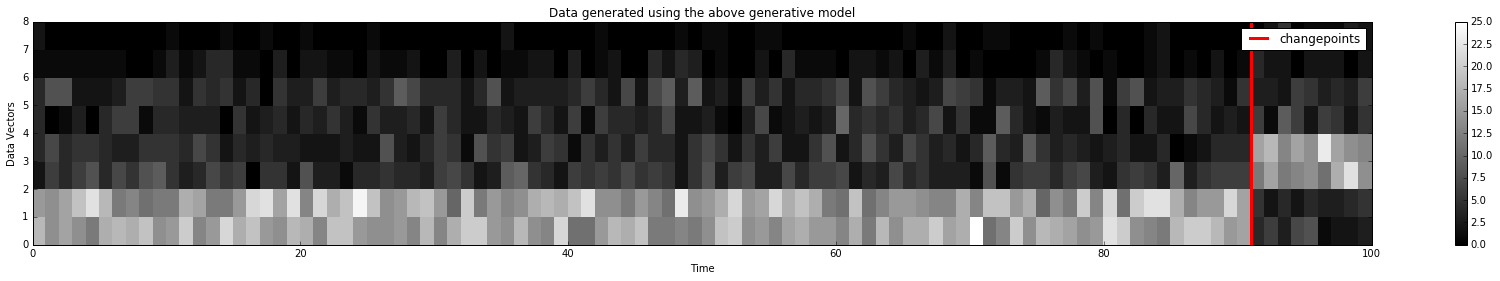

In [29]:
S = 3
M = 8
T = 100
dbcpm = DBCPM.init(S, M)
cps, C, S, H, V = dbcpm.gen_data(T)

def plot_hist(data,xlines,title="",xlabel="",ylabel="",label_='changepoints'):
    (K,T) = data.shape
    fig = plt.figure(figsize=(30,4))
    ax = fig.gca()
    y,x = np.mgrid[slice(0, M+1, 1),slice(0,T+1,1)]
    im = ax.pcolormesh(x, y, data, cmap=cm.gray)
    fig.colorbar(im)
    ax.hold(True)
    plt1 = ax.vlines(np.arange(0,T), 0, xlines*M, colors='r', linestyles='-',label=label_,linewidth='3')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(handles=[plt1])
    fig.canvas.draw()
    
plot_hist(V,C,title="Data generated using the above generative model", xlabel="Time",ylabel="Data Vectors")
print(dbcpm.B)

In [ ]:
# S: number of basis
# M: number of observations
B = np.zeros
a = normalize(np.ones(M))